In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# IMPORTS

In [3]:
# load the test image
def load_image(image_path):
    image = cv2.imread(image_path)
    return image

In [4]:
test_img = load_image("test_images/img23.jpg")

# 1. Function for the Preprocessing of Image
- Grayscale and Bilateral Filter

In [5]:
def preprocess_image(image):
    """Converts to grayscale and applies a bilateral filter"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17) 
    return bfilter

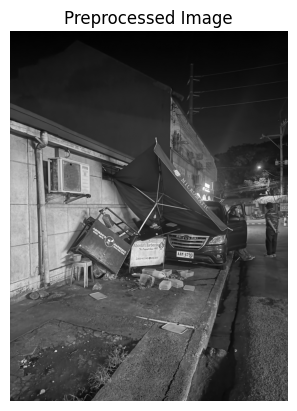

In [6]:
preprocessed_img = preprocess_image(test_img)
plt.imshow(preprocessed_img, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()

# 2. Function for the Image Pyramid

In [7]:
def pyramid(image, scale=1.5, min_size=(20, 20)):
    """
    Yields images at different scales
    Each step reduces the image size by the given scale factor
    Stops when the image is smaller than min_size
    """
    yield image  # Yield the original image

    while True:
        # Calculate new dimensions
        new_width = int(image.shape[1] / scale)
        new_height = int(image.shape[0] / scale)

        # Stop if the image is too small
        if new_width < min_size[0] or new_height < min_size[1]:
            break

        # Resize and yield the scaled image
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        yield image


Generated 11 images in the pyramid.


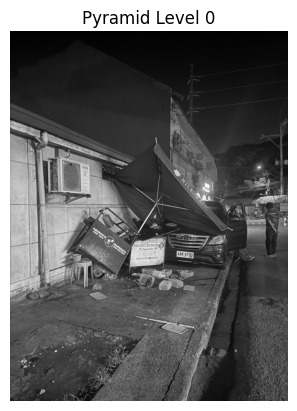

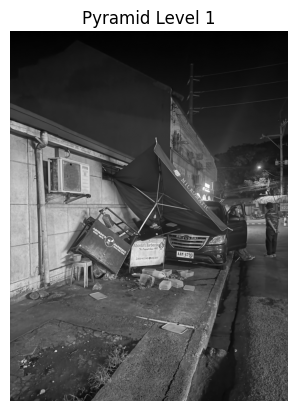

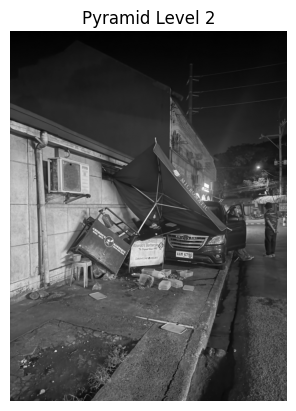

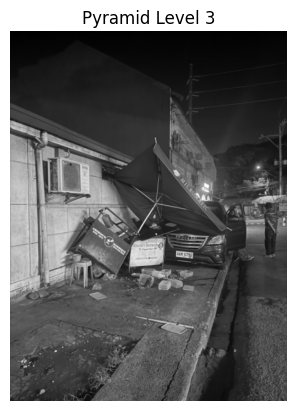

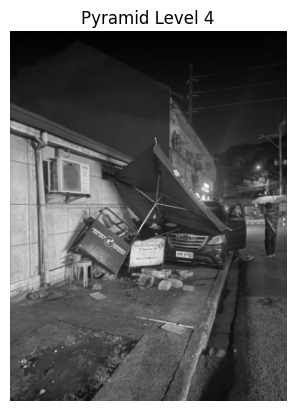

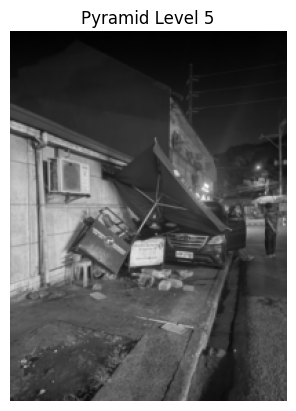

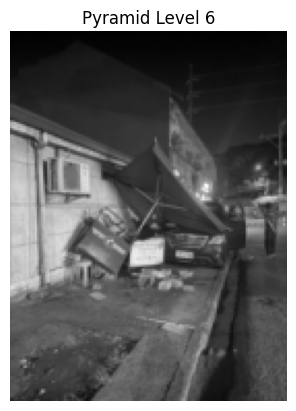

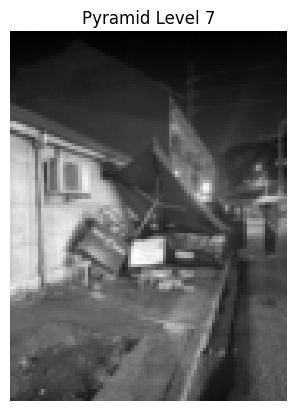

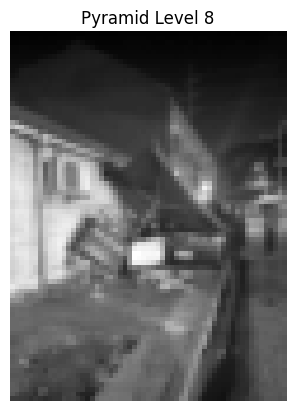

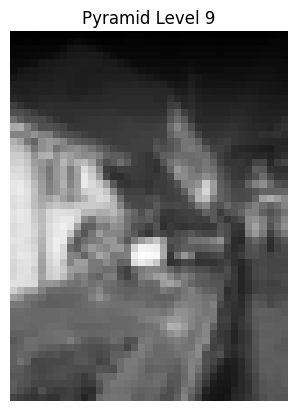

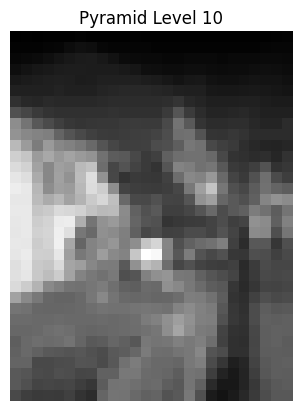

In [8]:
pyramid_images = list(pyramid(preprocessed_img))
print(f"Generated {len(pyramid_images)} images in the pyramid.")
for i, img in enumerate(pyramid_images):
    plt.imshow(img, cmap='gray')
    plt.title(f"Pyramid Level {i}")
    plt.axis('off')
    plt.show()

# 3. Finding the License Plate Contours

In [9]:
def find_plate_contour(processed_image):
    """Finds the 4-point contour of the license plate."""
    try:
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(processed_image, (7, 7), 0)
        edged = cv2.Canny(blurred, 50, 200)
        contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

        plate_contour = None
        for c in contours:
            """
            This helps identify shapes with 4 sides
            since license plates are rectangular
            """
            perimeter = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.018 * perimeter, True)

            if len(approx) == 4:
                (x, y, w, h) = cv2.boundingRect(approx)
                aspect_ratio = float(w) / h

                # Tune as needed but these values work for Philippine plates
                if 1.5 < aspect_ratio < 4.5 and w > 30 and h > 15:
                    plate_contour = approx
                    break

        return plate_contour
    except Exception as e:
        print(f"Error in find_plate_contour: {e}")
        return None

License plate contour found at pyramid level 0.


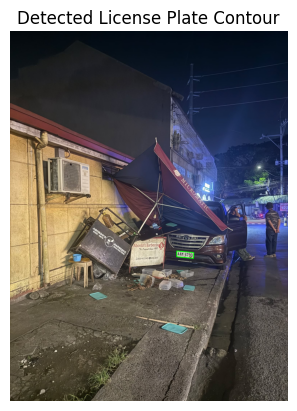

In [10]:
for i, img in enumerate(pyramid_images):
    plate_contour = find_plate_contour(img)
    if plate_contour is not None:
        print(f"License plate contour found at pyramid level {i}.")
        break

if plate_contour is not None:
    # Draw the contour on the original image
    output_img = test_img.copy()
    cv2.drawContours(output_img, [plate_contour], -1, (0, 255, 0), 3)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected License Plate Contour")
    plt.axis('off')
    plt.show()

# 4. Cropping the Image to Isolate the License Plate

In [11]:
def crop_plate(image, plate_contour, plate_type="car"):
    """Crops and warps the 4-point contour to a flat, top-down image. Supports car and motorcycle plate sizes."""
    try:
        # This is needed to ensure the points are in the correct order before warping
        pts = plate_contour.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")

        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)] # Top-left
        rect[2] = pts[np.argmax(s)] # Bottom-right

        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)] # Top-right
        rect[3] = pts[np.argmax(diff)] # Bottom-left

        """
        Philippine License Plate Sizes:
        For car plates, use 390x140
        For motorcycle plates, use 235x135
        """        
        if plate_type == "motorcycle":
            target_w = 235
            target_h = 135
        else:  # default to car
            target_w = 390
            target_h = 140

        dst = np.array([
            [0, 0],
            [target_w - 1, 0],
            [target_w - 1, target_h - 1],
            [0, target_h - 1]], dtype="float32")

        M = cv2.getPerspectiveTransform(rect, dst)
        cropped = cv2.warpPerspective(image, M, (target_w, target_h))

        cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        return cropped_gray
    
    except Exception as e:
        print(f"Error in crop_plate: {e}")
        return None

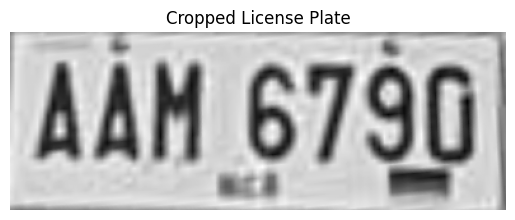

In [12]:
cropped_plate = crop_plate(test_img, plate_contour)
if cropped_plate is not None:
    plt.imshow(cropped_plate, cmap='gray')
    plt.title("Cropped License Plate")
    plt.axis('off')
    plt.show()
else:
    print("No license plate contour found.")

# 5. Load the Template of the Characters for Matching

In [13]:
def load_templates(template_directory="templates"):
    """
    Loads all templates from a directory into a dictionary.
    """
    templates = {}
    if not os.path.exists(template_directory):
        print(f"Error: Template directory not found at {template_directory}")
        return None

    print(f"Loading templates from {template_directory}...")
    for filename in os.listdir(template_directory):
        if filename.endswith(('.png', '.jpg', '.bmp')):
            char_name = os.path.splitext(filename)[0]
            template_img = cv2.imread(os.path.join(template_directory, filename), 
                                      cv2.IMREAD_GRAYSCALE)
            
            if template_img is None: 
                continue
            # Use THRESH_BINARY to match the segmented characters (white on black)
            _, template_thresh = cv2.threshold(template_img, 127, 255, cv2.THRESH_BINARY)
            
            # CRITICAL: Tightly crop the template to remove padding/whitespace
            """
            If not cropped, template matching may not work well due to extra borders
            since the segmented characters will be tightly cropped
            """
            coords = cv2.findNonZero(template_thresh)
            if coords is not None:
                x, y, w, h = cv2.boundingRect(coords)
                template_thresh = template_thresh[y:y+h, x:x+w]
            
            templates[char_name] = template_thresh
    
    print(f"Loaded {len(templates)} templates.")
    print(f"Available characters: {sorted(templates.keys())}")
    return templates

In [14]:
char_templates = load_templates()

Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


# 6. Segment the Characters in the Cropped License Plate

In [15]:
def segment_characters(warped_plate):
    """Finds, deskews, and sorts character contours."""
    try:
        # Threshold the plate image
        thresh = cv2.threshold(warped_plate, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        character_data = []
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            aspect_ratio = w / float(h)
            if 0.1 < aspect_ratio < 1.0 and h > 20 and w > 5:
                rect = cv2.minAreaRect(c)
                box = cv2.boxPoints(rect)
                box = np.float32(box)

                # Order points: top-left, top-right, bottom-right, bottom-left
                s = box.sum(axis=1)
                diff = np.diff(box, axis=1)
                ordered_pts = np.array([
                    box[np.argmin(s)],
                    box[np.argmin(diff)],
                    box[np.argmax(s)],
                    box[np.argmax(diff)]
                ], dtype="float32")

                # Standard character size same as templates
                target_w, target_h = 40, 80
                dst = np.array([
                    [0, 0],
                    [target_w - 1, 0],
                    [target_w - 1, target_h - 1],
                    [0, target_h - 1]
                ], dtype="float32")

                M = cv2.getPerspectiveTransform(ordered_pts, dst)
                deskewed_char = cv2.warpPerspective(thresh, M, (target_w, target_h))
                character_data.append((x, deskewed_char))

        if not character_data:
            return None, None, None

        # Sort by x-coordinate
        character_data.sort(key=lambda item: item[0])
        sorted_characters = [img for _, img in character_data]
        sorted_rois = [None] * len(sorted_characters)  # Placeholder if ROIs needed

        return sorted_characters, sorted_rois, thresh

    except Exception as e:
        print(f"Error in segment_characters: {e}")
        return None, None, None

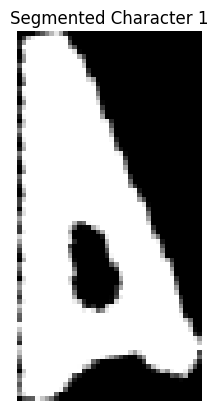

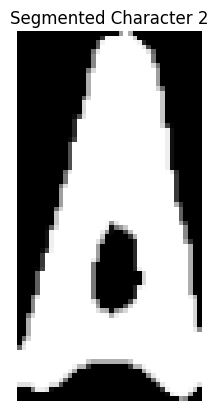

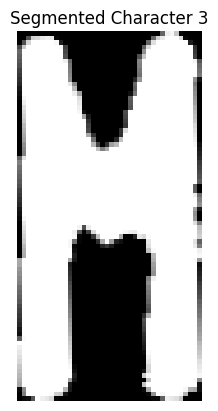

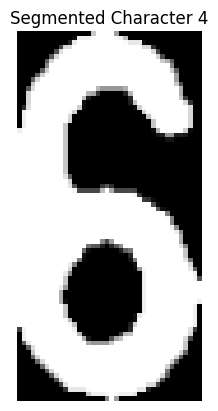

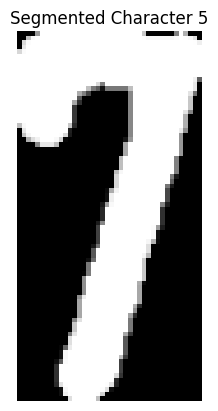

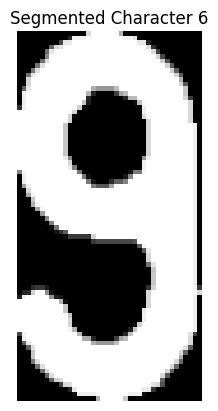

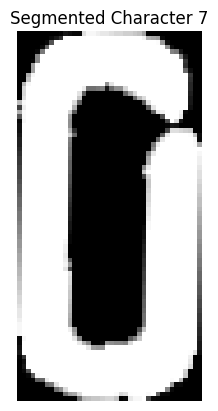

In [16]:
segmented_chars, rois, thresh_img = segment_characters(cropped_plate)
if segmented_chars is not None:
    for i, char_img in enumerate(segmented_chars):
        plt.imshow(char_img, cmap='gray')
        plt.title(f"Segmented Character {i+1}")
        plt.axis('off')
        plt.show()

# 7. Recognize the Characters using Template Matching

In [17]:
def recognize_characters_template_matching(character_images, templates):
    """Identifies characters using cv2.matchTemplate."""
    if not templates:
        return "Template DB not loaded"
    if not character_images:
        return ""

    plate_text = ""
    
    # Same size for matching
    TARGET_W = 40 
    TARGET_H = 80 

    for char_img in character_images:
        best_match_score = -1
        best_match_char = "?"

        # Resize character to standard size
        char_resized = cv2.resize(char_img, (TARGET_W, TARGET_H), interpolation=cv2.INTER_AREA)

        for char_name, template in templates.items():
            # Resize template to standard size
            template_resized = cv2.resize(template, (TARGET_W, TARGET_H), interpolation=cv2.INTER_AREA)

            # Perform template matching and get the best match score
            result = cv2.matchTemplate(char_resized, template_resized, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, _ = cv2.minMaxLoc(result)
            if max_val > best_match_score:
                best_match_score = max_val
                best_match_char = char_name

        # Confidence threshold for accepting a match (tune as needed)
        if best_match_score > 0.4: 
            plate_text += best_match_char
        else:
            plate_text += "?"

    return plate_text

In [18]:
matched_text = recognize_characters_template_matching(segmented_chars, char_templates)
print(f"Recognized License Plate Text: {matched_text}")

Recognized License Plate Text: ?AHO780


# 8. Summarizing the Process (for importing)

In [19]:
def recognize_license_plate(image_path, template_directory="templates"):
    """Full process to recognize license plate from image."""
    image = load_image(image_path)
    preprocessed = preprocess_image(image)

    plate_contour = None
    for img in pyramid(preprocessed):
        plate_contour = find_plate_contour(img)
        if plate_contour is not None:
            break

    if plate_contour is None:
        return "License plate contour not found"

    cropped_plate = crop_plate(image, plate_contour)
    if cropped_plate is None:
        return "Failed to crop license plate"

    templates = load_templates(template_directory)
    segmented_chars, _, _ = segment_characters(cropped_plate)
    if segmented_chars is None:
        return "No characters segmented"

    recognized_text = recognize_characters_template_matching(segmented_chars, templates)
    return recognized_text

# 9. Testing on all the test_images

Processing: test_images\img1.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


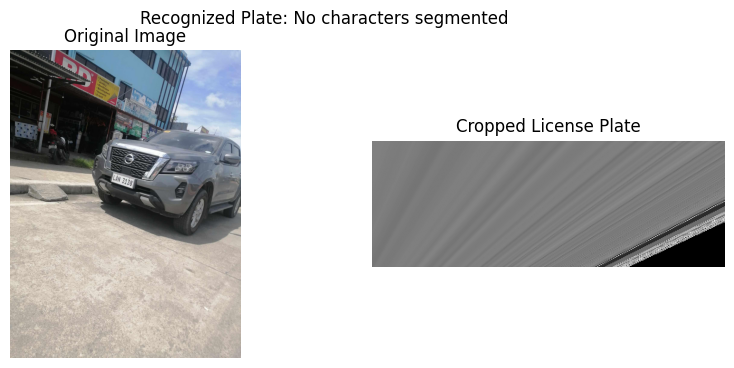

Processing: test_images\img10.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


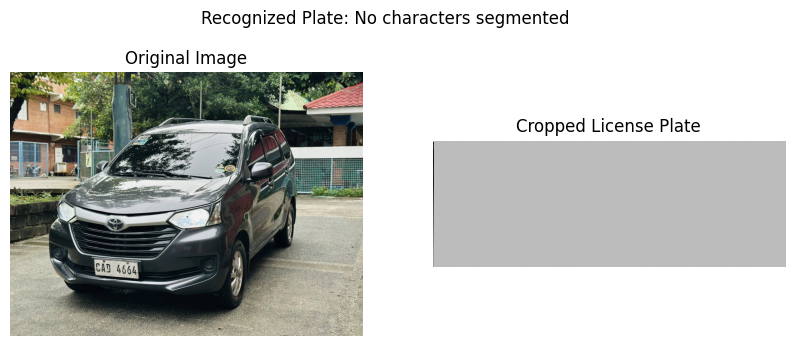

Processing: test_images\img11.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


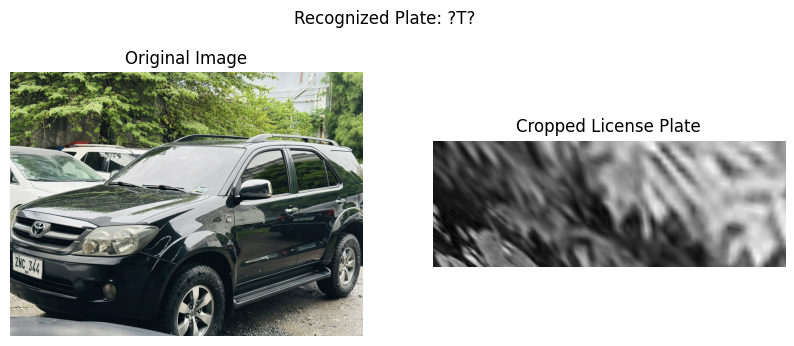

Processing: test_images\img12.jpg
Error in crop_plate: 'NoneType' object has no attribute 'reshape'


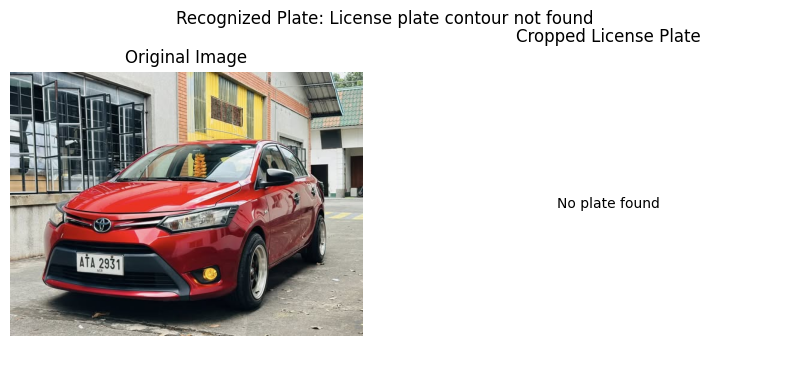

Processing: test_images\img13.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


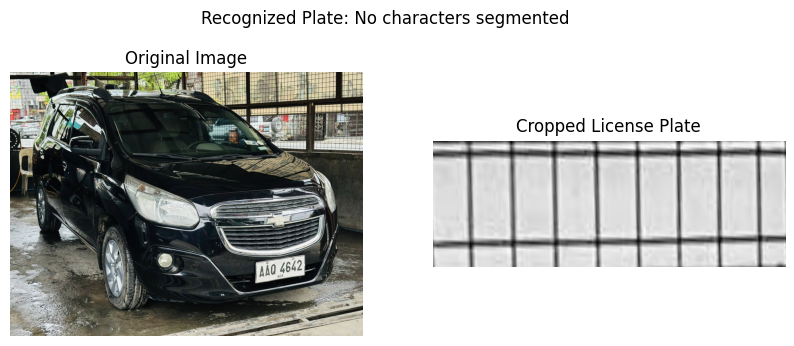

Processing: test_images\img14.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


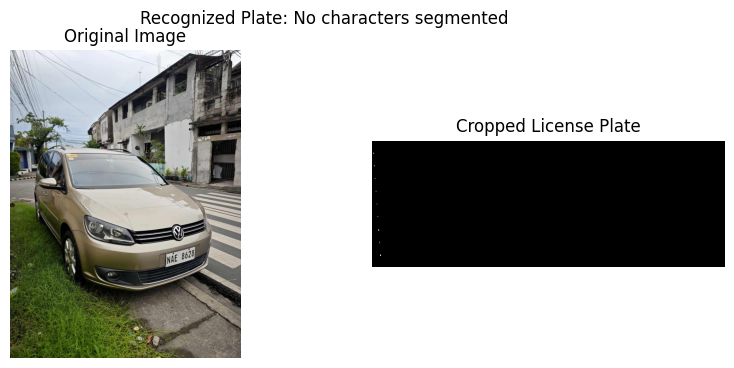

Processing: test_images\img15.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


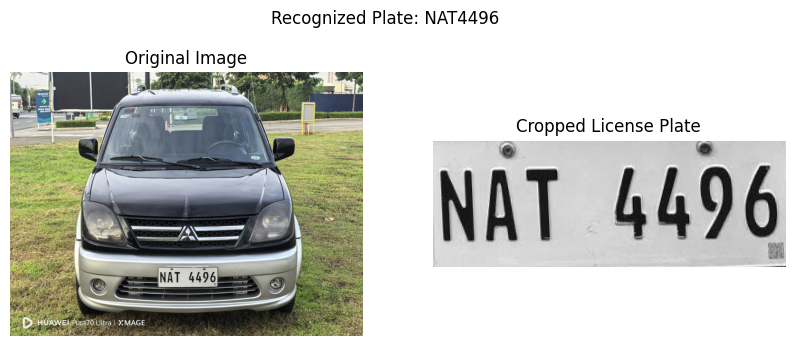

Processing: test_images\img16.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


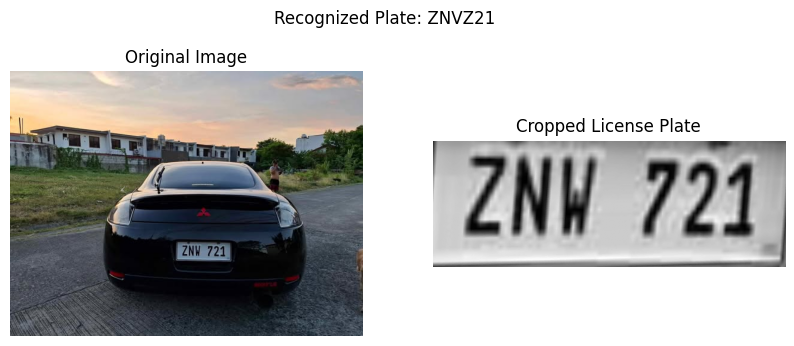

Processing: test_images\img17.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


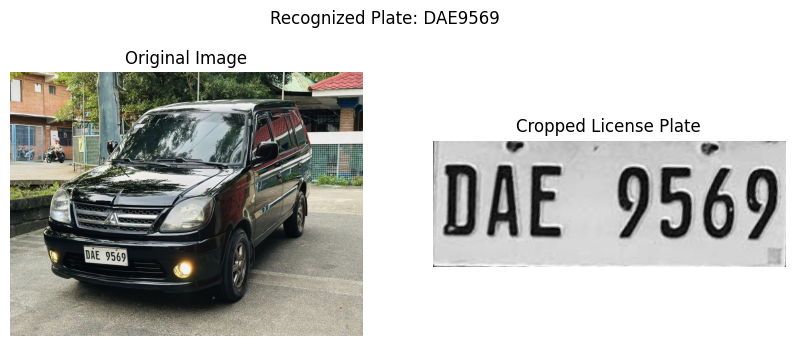

Processing: test_images\img18.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


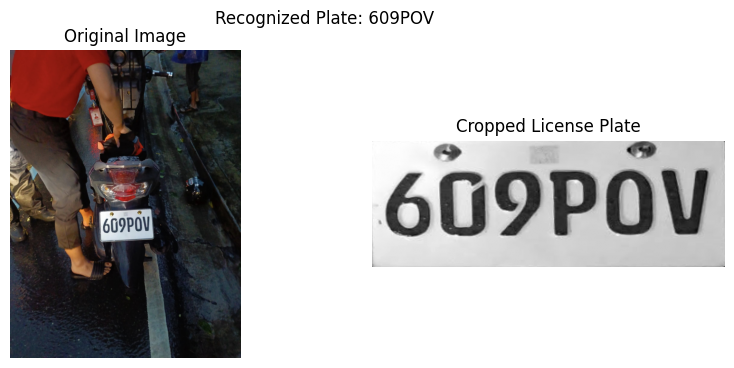

Processing: test_images\img19.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


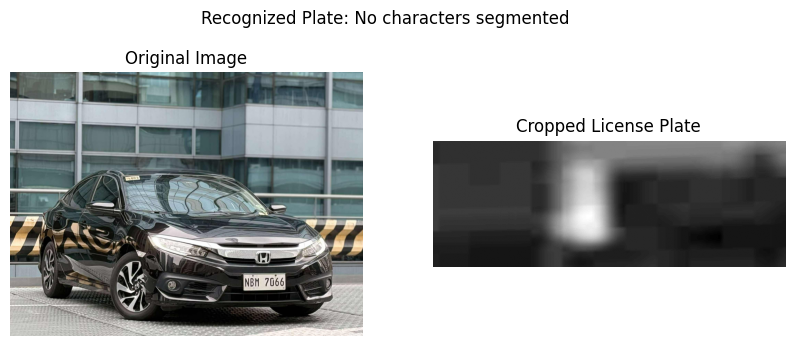

Processing: test_images\img2.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


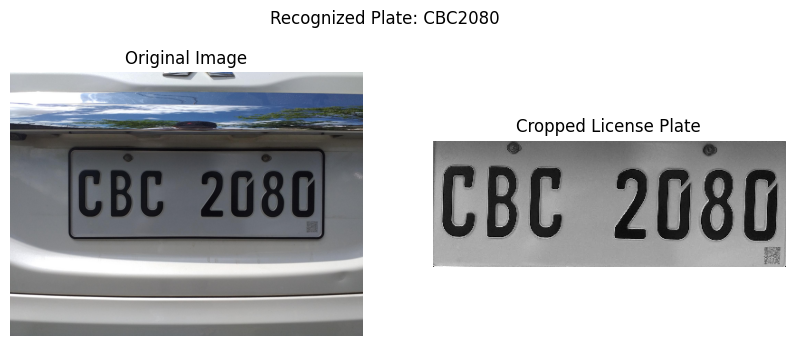

Processing: test_images\img20.jpg
Error in crop_plate: 'NoneType' object has no attribute 'reshape'


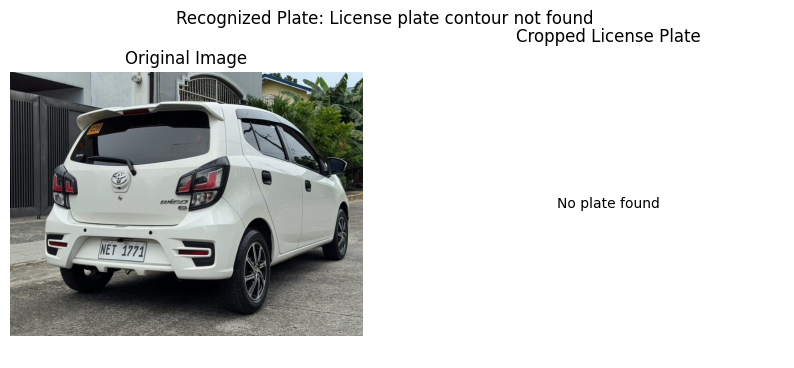

Processing: test_images\img21.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


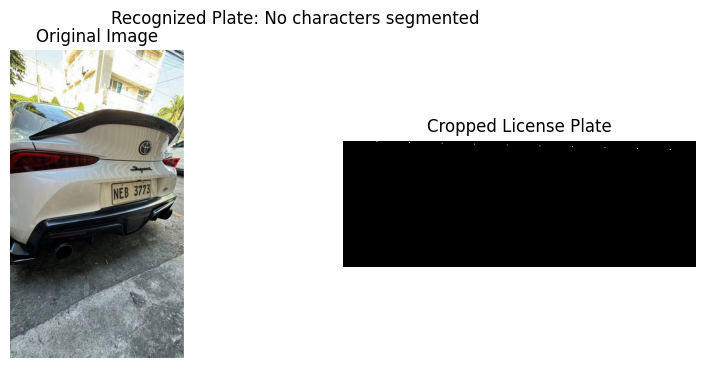

Processing: test_images\img22.jpg
Error in crop_plate: 'NoneType' object has no attribute 'reshape'


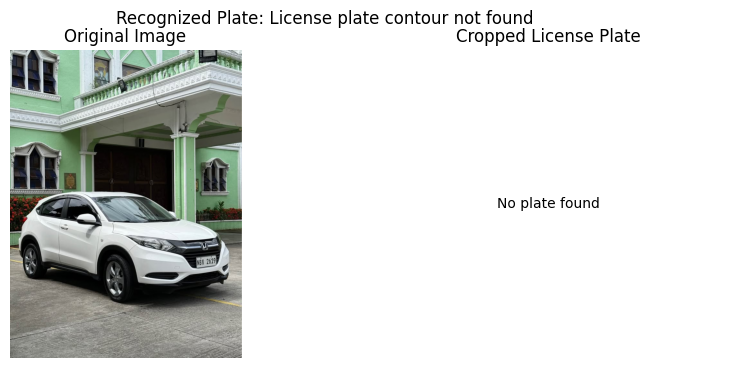

Processing: test_images\img23.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


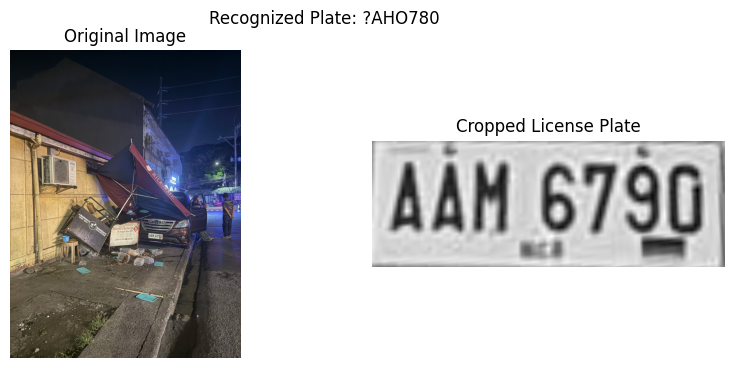

Processing: test_images\img3.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


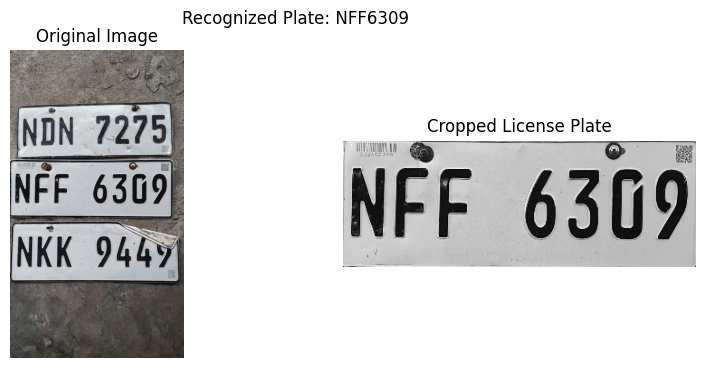

Processing: test_images\img4.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


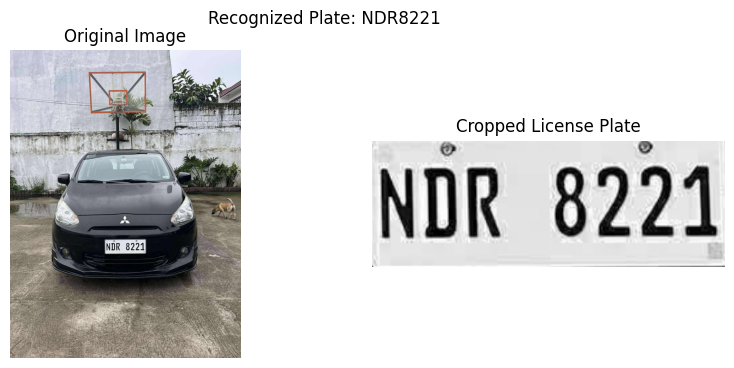

Processing: test_images\img5.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


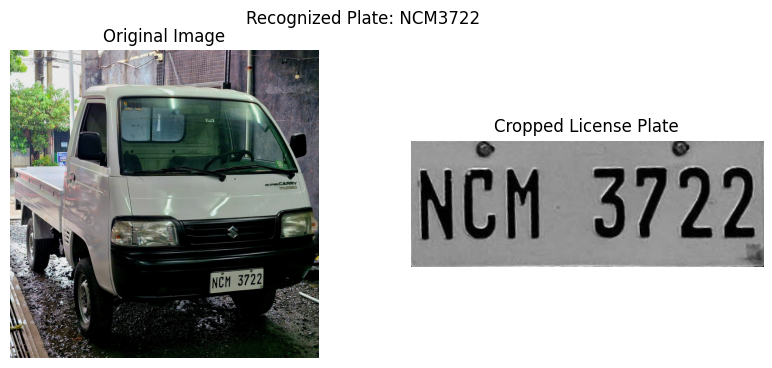

Processing: test_images\img6.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


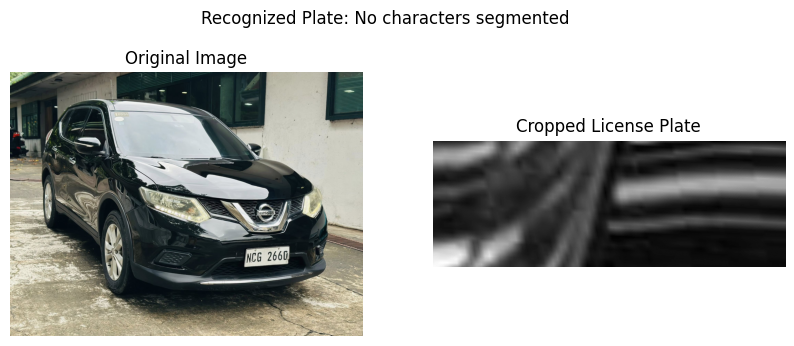

Processing: test_images\img7.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


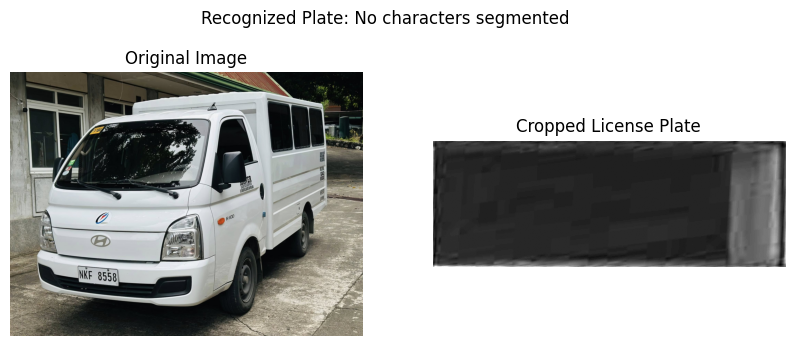

Processing: test_images\img8.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


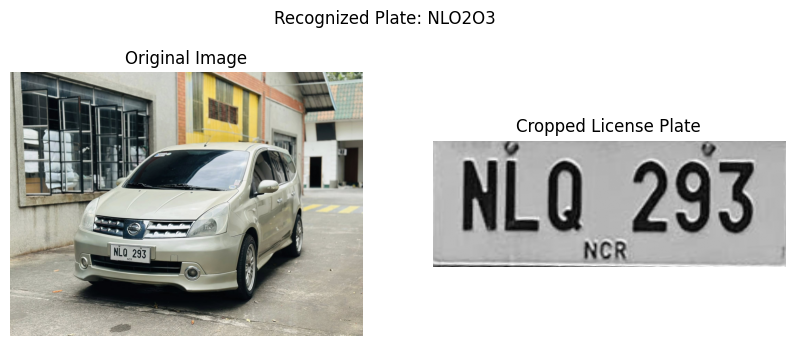

Processing: test_images\img9.jpg
Loading templates from templates...
Loaded 36 templates.
Available characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


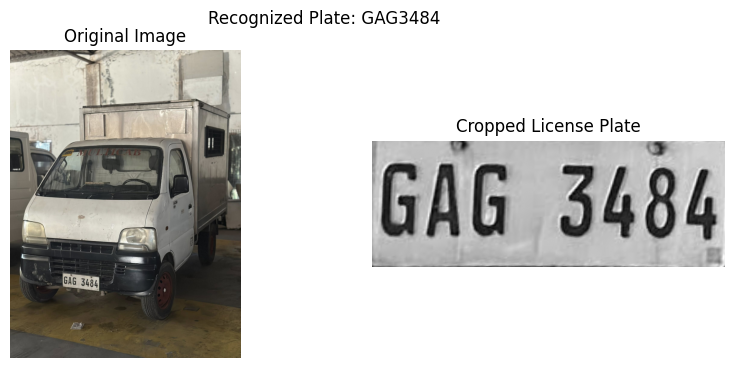

In [20]:
import glob

test_dir = "test_images"
image_paths = glob.glob(os.path.join(test_dir, "*.jpg")) + glob.glob(os.path.join(test_dir, "*.png"))

for img_path in image_paths:
    print(f"Processing: {img_path}")
    result = recognize_license_plate(img_path, "templates")
    input_image = load_image(img_path)
    preprocessed_input = preprocess_image(input_image)

    # Find the contour in the input image
    plate_contour_input = None
    for img in pyramid(preprocessed_input):
        plate_contour_input = find_plate_contour(img)
        if plate_contour_input is not None:
            break

    cropped_plate_input = crop_plate(input_image, plate_contour_input)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    if cropped_plate_input is not None:
        plt.imshow(cropped_plate_input, cmap='gray')
        plt.title("Cropped License Plate")
    else:
        plt.text(0.5, 0.5, "No plate found", ha='center', va='center')
        plt.title("Cropped License Plate")
    plt.axis('off')

    plt.suptitle(f"Recognized Plate: {result}")
    plt.show()